In [4]:
import os
import json
import pandas as pd

base_path = "."
target_keys = [
    "timestamp",
    "model_purpose",
    # "model",
    "special_features",
    "f1",
    "recall",
    "precision",
    "bal_accuracy",
    "classification_report__no dia__f1-score",
    "classification_report__pre__f1-score",
    "classification_report__dia__f1-score",
]

subdirs = [
    d for d in os.listdir(base_path) if os.path.isdir(d) and not d.startswith(".")
]


rows = []

for d in subdirs:
    result_path = os.path.join(base_path, d, f"{d}.results.json")
    row = {}
    if os.path.exists(result_path):
        with open(result_path, "r") as f:
            data = json.load(f)

        for key in target_keys:
            val = data
            for part in key.split("__"):
                if isinstance(val, dict) and part in val:
                    val = val[part]
                else:
                    val = None
                    break
            row[key] = val
    else:
        for key in target_keys:
            row[key] = None
    row["dir"] = d
    rows.append(row)


df = pd.DataFrame(rows)
df.set_index("timestamp", inplace=True)

for col in [c for c in df.columns if c.startswith("classification_report")]:
    df.rename(
        columns={
            col: col.replace("classification_report__", "cl_rep__").replace(" ", "_")
        },
        inplace=True,
    )

df.sort_values(by="f1", ascending=False, inplace=True)
display(df)


,model_purpose,special_features,f1,recall,precision,bal_accuracy,cl_rep__no_dia__f1-score,cl_rep__pre__f1-score,cl_rep__dia__f1-score,dir
timestamp,,,,,,,,,,
20250701155146,baseline,smote,0.821597,0.836901,0.809270,0.416051,0.909227,0.354720,0.004353,20250701155146_RandomForestClassifier_f100821_...
20250701140915,baseline,,0.815238,0.851195,0.804250,0.379199,0.918635,0.243546,0.002304,20250701140915_RandomForestClassifier_f100815_...
20250701161944,baseline,"smote,minority",0.813741,0.847943,0.801418,0.379551,0.916843,0.243216,0.006501,20250701161944_RandomForestClassifier_f100813_...


In [19]:
# df as markdown table
from tabulate import tabulate
print(tabulate(df.reset_index(), headers="keys", tablefmt="github", showindex=False))

|      timestamp | model_purpose   | special_features   |       f1 |   recall |   precision |   bal_accuracy |   cl_rep__no_dia__f1-score |   cl_rep__pre__f1-score |   cl_rep__dia__f1-score | dir                                                                   |
|----------------|-----------------|--------------------|----------|----------|-------------|----------------|----------------------------|-------------------------|-------------------------|-----------------------------------------------------------------------|
| 20250701155146 | baseline        | smote              | 0.821597 | 0.836901 |    0.80927  |       0.416051 |                   0.909227 |                0.35472  |              0.00435256 | 20250701155146_RandomForestClassifier_f100821_baseline                |
| 20250701140915 | baseline        |                    | 0.815238 | 0.851195 |    0.80425  |       0.379199 |                   0.918635 |                0.243546 |              0.00230415 | 20250701140915_R

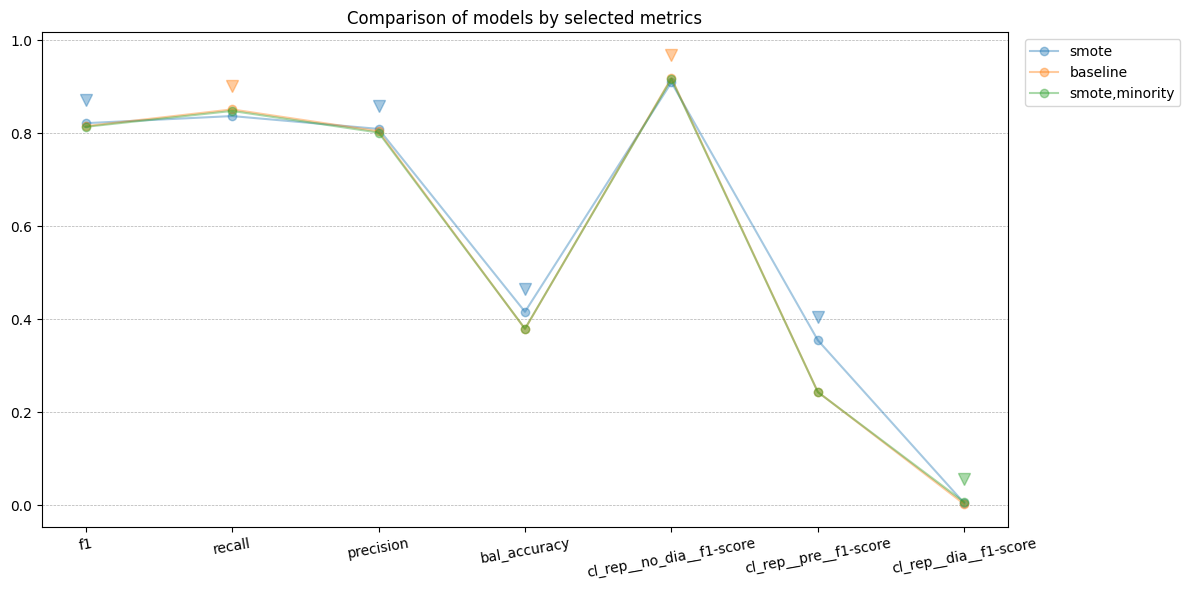

In [17]:
import matplotlib.pyplot as plt

# Select only numeric columns
num_cols = df.select_dtypes(include="number").columns

# Fallback for row labels
def get_row_label(row):
    if pd.notna(row.get("special_features")) and row["special_features"] != "":
        return str(row["special_features"])
    return str(row.get("model_purpose", "row"))

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))
lines = []
alpha = 0.4

# Plot each row
for idx, row in df.iterrows():
    label = get_row_label(row)
    line, = ax.plot(num_cols, row[num_cols], marker="o", label=label, alpha=alpha)
    lines.append((idx, line, row))

# Mark maximum value per column
for col in num_cols:
    max_idx = df[col].idxmax()
    row = df.loc[max_idx]
    y = row[col] + 0.05
    x = list(num_cols).index(col)

    # Get the color of the corresponding line
    line_color = next((l.get_color() for i, l, r in lines if i == max_idx), "black")
    ax.plot(x, y, marker="v", color=line_color, markersize=8, alpha=alpha)

# Axis and legend settings
ax.set_xticks(range(len(num_cols)))
ax.set_xticklabels(num_cols, rotation=10)
ax.legend(bbox_to_anchor=(1.01, 1.0), loc="upper left")
ax.set_title("Comparison of models by selected metrics")
ax.grid(axis="y", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()
